# Offline policy training & evaluation

Inspiration from [this turorial](https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/tutorials/off_policy_evaluation.html). We use an **incrementally trained** VW policy with adf-format data.


In [1]:
import os
import random
import vowpalwabbit

In [2]:
if os.path.isfile("candidate_model.vw"):
    os.remove("candidate_model.vw")

random.seed()

In [37]:
from operator import le


def get_examples(filename):
    examples = list()
    with open(filename, "r") as fin:
        example = list()
        for line in fin:
            if line.startswith("shared |"):
                if len(example) > 0:
                    examples.append(example)
                example = list()
                example.append(line.strip("\n"))
            else:
                if len(line.strip("\n")) > 0:
                    example.append(line.strip("\n"))
        examples.append(example)
    return examples


def dialogue_length(line):
    return len(line.split("|")[1].strip().split(" "))


def calculate_dialogue_lengths(examples):
    lengths = dict()
    for e in examples:
        length = dialogue_length(e[0])
        if length in lengths:
            lengths[length] += 1
        else:
            lengths[length] = 1
    return lengths


def get_average(lengths: dict):
    sum = 0
    count = 0
    for k, v in lengths.items():
        sum += k * v
        count += v
    return sum / count, count


def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if sum_prob > draw:
            return index, prob

In [38]:
examples_new = get_examples("applications/mock-dialogues-service/new_data.dat")
examples_old = get_examples("data/data.dat")

random.shuffle(examples_old)
random.shuffle(examples_new)

data = examples_old + examples_new
random.shuffle(data)

# data_train = data[: round(0.8 * len(data))]
# data_validate = data[round(0.8 * len(data)) :]
data_train = examples_old
data_validate = examples_new

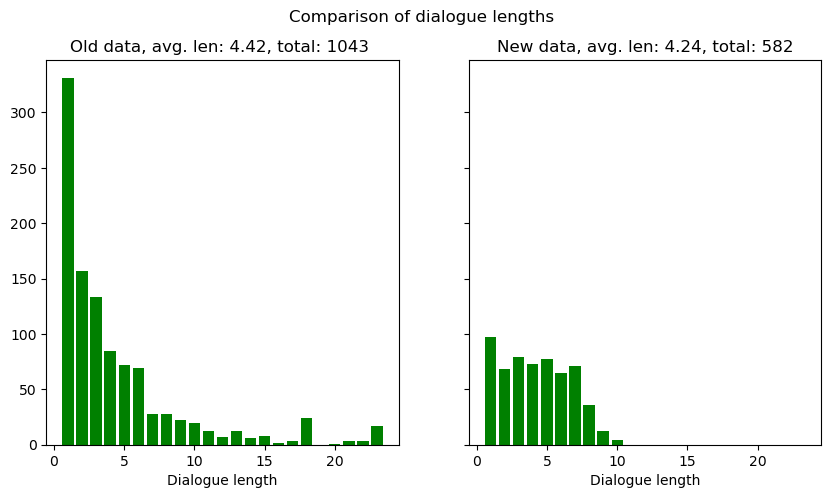

In [49]:
import matplotlib.pyplot as plt

old = calculate_dialogue_lengths(examples_old)
old_average, old_count = get_average(old)
new = calculate_dialogue_lengths(examples_new)
new_average, new_count = get_average(new)

fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    sharey=True,
    sharex=True,
    figsize=(10, 5),
)
fig.suptitle("Comparison of dialogue lengths")


ax1.bar(
    list(old.keys()),
    old.values(),
    color="g",
)
ax1.set(xlabel="Dialogue length")
ax1.set_title(f"Old data, avg. len: {old_average:,.2f}, total: {old_count} ")
ax2.bar(list(new.keys()), new.values(), color="g")
ax2.set_title(f"New data, avg. len: {new_average:,.2f}, total: {new_count}")
ax2.set(xlabel="Dialogue length")

plt.show()

Train the model.


In [155]:
cb_type = "ips"

vw_train = vowpalwabbit.Workspace(
    cb_explore_adf=True,
    cb_type=cb_type,
    f="candidate_model.vw",
)

final_regressor = candidate_model.vw
using no cache
Reading datafile = none
num sources = 0
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
cb_type = ips
Enabled learners: gd, scorer-identity, csoaa_ldf-rank, cb_adf, cb_explore_adf_greedy, shared_feature_merger
Input label = CB
Output pred = ACTION_PROBS
average  since         example        example        current        current  current
loss     last          counter         weight          label        predict features


In [156]:
for i in range(len(data_train)):
    vw_format = vw_train.parse(data_train[i])
    vw_train.learn(vw_format)
    vw_train.finish_example(vw_format)

1.100000 1.100000            1            1.0      0:1:0.091          0:0.1       50
0.575000 0.050000            2            2.0       0:1:0.25         1:0.96       60
0.287500 0.000000            4            4.0       0:0:0.17         3:0.96       50
0.164388 0.041275            8            8.0      0:1:0.083         2:0.95       33
0.103161 0.041935           16           16.0      0:0:0.077         2:0.95       36
0.276898 0.450635           32           32.0       0:1:0.11         2:0.96       64
0.393711 0.510524           64           64.0      0:1:0.083         2:0.95       33
0.245824 0.097936          128          128.0      0:0:0.083         2:0.95       44
0.424883 0.603943          256          256.0       0:0:0.11         3:0.96       72
0.376559 0.328234          512          512.0        0:1:0.1         4:0.96       81
0.318156 0.259754         1024         1024.0       0:0:0.14         3:0.96       48


In [157]:
vw_train.finish()


finished run
number of examples = 1043
weighted example sum = 1043.000000
weighted label sum = 0.000000
average loss = 0.315382
total feature number = 48366


In [158]:
vw_test = vowpalwabbit.Workspace(
    cb_explore_adf=True, cb_type=cb_type, i="candidate_model.vw", t=True
)

for i in range(len(data_validate)):
    vw_format = vw_train.parse(data_validate[i])
    vw_test.learn(vw_format)
    vw_test.finish_example(vw_format)
vw_test.finish()

only testing
using no cache
Reading datafile = none
num sources = 0
Num weight bits = 18
learning rate = 0.5
initial_t = 1043
power_t = 0.5
cb_type = ips
Enabled learners: gd, scorer-identity, csoaa_ldf-rank, cb_adf, cb_explore_adf_greedy, shared_feature_merger
Input label = CB
Output pred = ACTION_PROBS
average  since         example        example        current        current  current
loss     last          counter         weight          label        predict features
0.000000 0.000000            1            1.0      0:0:0.077         0:0.08       36
0.000000 0.000000            2            2.0      0:0:0.077         0:0.08       36
0.000000 0.000000            4            4.0      0:0:0.091          0:0.1       70
0.413194 0.826389            8            8.0       0:0:0.12         0:0.14       63
0.548864 0.684533           16           16.0       0:0:0.12         0:0.14       63
0.450337 0.351811           32           32.0       0:0:0.14         0:0.17       72
0.534913 0.619

In [159]:
sample = vw_train.predict(
    """shared | vaccines covid_stats 
| no_action vaccines covid_stats 
| icu_stats_form 
| vaccine_stats_form
| pharmacy_form
| ill_questionnaire_form
| ways_of_protection
| symptoms
| test_types
| test_cost
| what_to_do_if_positive
| underlying_conditions"""
)

print(sample)
print(sample_custom_pmf(sample))

[0.004545454401522875, 0.004545454401522875, 0.9545454382896423, 0.004545454401522875, 0.004545454401522875, 0.004545454401522875, 0.004545454401522875, 0.004545454401522875, 0.004545454401522875, 0.004545454401522875, 0.004545454401522875]
(2, 0.9545454551804471)


Testing


|                      | 0        | 100      | 200      | 400      | All      |
| -------------------- | -------- | -------- | -------- | -------- | -------- |
| number of examples   | 1043     | 1143     | 1243     | 1443     | 1625     |
| average loss         | 0.330858 | 0.356043 | 0.363716 | 0.374223 | 0.407437 |
| total feature number | 48366    | 54194    | 60202    | 71476    | 82085    |


Useful sources:

- https://stackoverflow.com/questions/66996884/confusion-with-vowpal-wabbit-contextual-bandit-training-data-formatting
- https://stackoverflow.com/questions/28640837/vowpal-wabbit-how-to-represent-categorical-features/28643968#28643968
